In [15]:
%load_ext line_profiler
import matplotlib.pyplot as plt
import jax
from jax import numpy as np
from jax import jit
from jax import jacrev,jacfwd
from jax.debug import print as jprint
from functools import partial
# jax.config.update('jax_platform_name', 'cpu')

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [16]:
jax.config.update("jax_disable_jit", False)

In [17]:
jax.__version__

'0.4.31'

In [19]:
real = np.float32
@jit
def fill_ghost_cell(U: real, bc_type: int) -> real:
  U_border = np.zeros((NCELL+2*NG, NVAR), dtype=real)
  # jax.lax.slice(U_border, (ng, 0), (U.shape[0], 3)) = U

  U_border = U_border.at[NG:-NG,:].set(U[:,:])
  # if bc_type == 0: #"FOExtrap":
  for ii in range(NG):
     U_border = U_border.at[ii,:].set(U[0,:])
     U_border = U_border.at[-ii-1,:].set(U[-1,:])
  # elif bc_type == 1: #"periodic":
     # U_border = U_border.at[ii,:].set(U[ii,:])
     # U_border = U_border.at[-ii,:].set(U[-ii,:])
  # elif bc_type == 2: #"reflect":
  #   U_border[:NG,:] = U[NG:-1:,:]
  #   U_border[-NG:,:] = U[-NG:-1:,:]
  # else:
  #   raise NotImplementedError
  return U_border

# jnp.where(mask, other_fun(x), x)

# @jit
def riemann_ic(x, rl, ul, pl, rr, ur, pr):
  U = np.zeros((NCELL, 3))
  U_l0 = np.array([rl, rl*ul, pl/(GAMMA-1.) + 0.5*rl*ul**2])
  U_r0 = np.array([rr, rr*ur, pr/(GAMMA-1.) + 0.5*rr*ur**2])

  for i in range(NCELL):
      if (x[i]>0.0):
        # print(i,x[i],U[i],U_l0)
        U = U.at[i,:].set(U_r0)
      else:
        U = U.at[i,:].set(U_l0)

  # print('riemann ic',U)
  # for i in range(NCELL):
  #   jax.lax.cond(x[i]>0.0, lambda val: val.at[i].set(np.array([1,2,3])), lambda val: val.at[i].set(U_l0), U)
  #   jax.debug.print("i={}, x(i)={}, U(i)={}", i, x[i]>0.0, U[i])
  # # jax.debug.print("x: {}",x)
  # jax.debug.print("U: {}",U)
  return U

@jit
def cons2prim(U: real) -> real:
  rho = U[0]
  u = U[1] / U[0]
  p = (GAMMA - 1) * (U[2] - 0.5 * rho * u**2)
  return np.array([rho,u,p])
    
@jit
def eigenvalues(U: real) -> real:
    rho = U[0]
    u = U[1] / U[0]
    p = (GAMMA - 1) * (U[2] - 0.5 * rho * u**2)
    return abs(u) + (GAMMA*p/rho)**0.5

@jit
def flux(U: real) -> real:
    q = cons2prim(U)
    rho = q[0]
    u = q[1]
    p = q[2]
    return np.array([rho * u, rho * u**2 + p, u * (U[2] + p)])

@jit
def weno(s):
  # WENO Z5. Ref: https://doi.org/10.1016/j.jcp.2007.11.038
  eps = 1e-6
  beta = np.array([(13. / 12.) * (s[2] - 2 * s[1] + s[0])**2 + 0.25 * (3 * s[2] - 4 * s[1] + s[0])**2,
                  (13. / 12.) * (s[3] - 2 * s[2] + s[1])**2 + 0.25 * (s[3] - s[1])**2,
                  (13. / 12.) * (s[4] - 2 * s[3] + s[2])**2 + 0.25 * (s[4] - 4 * s[3] + 3 * s[2])**2])

  tau = np.abs(beta[2] - beta[0])
  # jax.debug.print("tau: {}",tau)
  beta = beta.at[0].set((1.0 + tau / (eps + beta[0])) * 3.0)
  beta = beta.at[1].set((1.0 + tau / (eps + beta[1])) * 6.0)
  beta = beta.at[2].set(1.0 + tau / (eps + beta[2]))
    
  beta1 = 1.0 / (beta[2] + beta[1] + beta[0])

  v = np.array([2 * s[2] + 5 * s[1] - s[0],
                -s[3] + 5 * s[2] + 2 * s[1],
                11 * s[2] - 7 * s[3] + 2 * s[4]])

  sm = beta1 / 6.0 * (beta[2] * v[2] + beta[1] * v[1] + beta[0] * v[0])
  # if (np.isnan(sm)): print("WARNING: isnan(sm)")
  return sm

@jit
def flux_int(Uc: real, fc: real, lambda_max: real) -> real:
    
    # Characteristic transformations
    Uave  = (Uc[NG-1] + Uc[NG])/2 # arithmetic ave or can do roe average
    
    J = jacrev(flux)
    lambdas, R = np.linalg.eig(J(Uave))
    R = np.real(R)
    L = np.linalg.inv(R)
    f2g = lambda ff: R@ff
    g2f = lambda ff: L@ff
    # print(R@L)
    
    # Stencil Flux-splitting
    # lambda_max = np.real(np.max(lambdas))
    fp = (fc + lambda_max*Uc) / 2
    fm = (fc - lambda_max*Uc) / 2
    
    # transform to characteristic variables
    gp = jax.vmap(f2g, in_axes=0, out_axes=0)(fp)
    gm = jax.vmap(f2g, in_axes=0, out_axes=0)(fm)
    
    # weno interpolation
    gpL = jax.vmap(lambda gg: weno(np.flip(gg[ :2*NG-1])), in_axes=1, out_axes=0)(gp)
    gmR = jax.vmap(lambda gg: weno(gg[1:2*NG]), in_axes=1, out_axes=0)(gm)
    
    # transform characteristic to flux variables
    fint = g2f(gpL+gmR)
    # fint = gpL+gmR
    return fint

@jit
def rhs_euler_ad(U: real, dx: real, bc_type: int) -> real:
    # Fill ghost cells
    U_field = fill_ghost_cell(U, bc_type)
    f_field = jax.vmap(flux, in_axes=0, out_axes=0)(U_field)  
    lambda_field = jax.vmap(eigenvalues, in_axes=0, out_axes=0)(U_field)
    fint = np.zeros((NCELL+1,NVAR), dtype=real)

    # stencils =
    for iface in range(NCELL+1):
        i1 = iface
        i2 = iface+2*NG
        lambda_max = np.max(jax.lax.slice_in_dim(lambda_field, i1, i2, stride=1, axis=0))
        uslice = jax.lax.slice_in_dim(U_field,i1,i2,axis=0)
        fslice = jax.lax.slice_in_dim(f_field,i1,i2,axis=0)
        fint = fint.at[iface].set(flux_int(uslice,fslice,lambda_max))
    
    return (fint[:-1,:] - fint[1:,:]) / dx

@jit
def rk3_euler_ad(U: real, dx: real, dt: real, bc_type: int) -> real:
  # SSP-RK3
  U1 = U + dt * (rhs_euler_ad(U, dx, bc_type))
  U2 = 0.75 * U + 0.25 * (U1 + dt * (rhs_euler_ad(U1, dx, bc_type)))
  return (U + 2*(U2 + dt * (rhs_euler_ad(U2, dx, bc_type)))) / 3

def main():
    global NG    
    global NVAR  
    global NCELL
    global GAMMA
    GAMMA = 1.4
    NG=3
    NVAR=3
    NCELL=100
    
    x = np.linspace(-1.0, 1.0, NCELL+1, dtype=real)
    x = (x[:-1] + x[1:]) / 2
    
    rl = 1
    ul = -1
    pl = 1
    rr = 1
    ur = 1
    pr = 1
    u = riemann_ic(x, rl, ul, pl, rr, ur, pr)
    # print(u)
    for i in range(3):
      plt.subplot(1,3,i+1)
      plt.plot(x, u[:,i], 'k--', label=rf"$t = 0$")
    
    dx = x[1] - x[0]
    t_end = 0.02
    dt = 0.001
    bc_type=0
    
    for i in range(int(t_end/dt)+1):
        print(i,'/',int(t_end/dt),end='\r')
        u = rk3_euler_ad(u, dx, dt,bc_type)
    
    for i in range(3):
      plt.subplot(1,3,i+1)
      plt.plot(x, u[:,i], label=rf"$t = {t_end}$")
      plt.xlabel("$x$")
    plt.legend()
    plt.tight_layout()

2024-08-05 18:50:34.805234: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 40m3.672489259s

********************************
[Compiling module jit_rk3_euler_ad] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


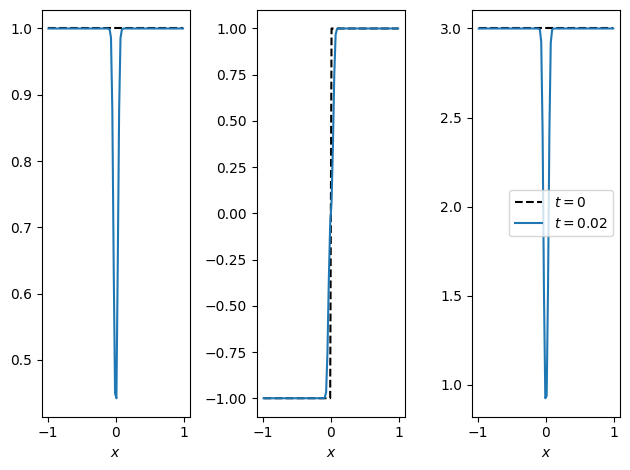

Timer unit: 1e-09 s

Total time: 2445.41 s
File: /tmp/ipykernel_57416/130494354.py
Function: main at line 149

Line #      Hits         Time  Per Hit   % Time  Line Contents
   149                                           def main():
   150                                               global NG    
   151                                               global NVAR  
   152                                               global NCELL
   153                                               global GAMMA
   154         1       1180.0   1180.0      0.0      GAMMA = 1.4
   155         1        447.0    447.0      0.0      NG=3
   156         1        351.0    351.0      0.0      NVAR=3
   157         1        372.0    372.0      0.0      NCELL=100
   158                                               
   159         1    2690769.0    3e+06      0.0      x = np.linspace(-1.0, 1.0, NCELL+1, dtype=real)
   160         1    3145521.0    3e+06      0.0      x = (x[:-1] + x[1:]) / 2
   161              

In [20]:
%lprun -f main main()

In [9]:
# %lprun -f main main()

In [21]:
# # @jit
# def rhs_euler_ad(U: real, dx: real, bc_type: int) -> real:
#     # Fill ghost cells
#     U_field = fill_ghost_cell(U, bc_type)
#     f_field = jax.vmap(flux, in_axes=0, out_axes=0)(U_field)  
#     lambda_field = jax.vmap(eigenvalues, in_axes=0, out_axes=0)(U_field)
    
#     fint = np.zeros((NCELL+1,NVAR), dtype=real)
    
#     f2g = lambda ff: R@ff[:]
#     g2f = lambda ff: L@ff[:]


#     for iface in range(NCELL+1):
#         U_sten = U_field[iface:iface+2*NG]
        
#         # Characteristic transformation
#         Uave  = (U_sten[NG-1] + U_sten[NG])/2 # arithmetic ave or can do roe average
#         J = jacfwd(flux)
#         lambdas, R = np.linalg.eig(J(Uave))
#         R = np.real(R)
#         L = np.linalg.inv(R)
#         # print(R@L)
        
#         # Stencil Flux-splitting
#         fc = f_field[iface:iface+2*NG,:]
#         # lambda_max = np.max(lambda_field[iface:iface+2*NG])
#         lambda_max = np.real(np.max(lambdas))
#         fp = (fc[:,:] + lambda_max*U_sten[:,:]) / 2
#         fm = (fc[:,:] - lambda_max*U_sten[:,:]) / 2
        
#         # transform to characteristic variables
#         gp = jax.vmap(f2g, in_axes=0, out_axes=0)(fp)
#         gm = jax.vmap(f2g, in_axes=0, out_axes=0)(fm)
#         # jprint("{}",gp)
#         fpL = jax.vmap(lambda vv: weno(np.flip(vv[ :2*NG-1])), in_axes=1, out_axes=0)(gp)
#         fmR = jax.vmap(lambda vv: weno(vv[1:2*NG]), in_axes=1, out_axes=0)(gm)
#         # jprint("{}",fpL)
#         fint.at[iface,:].set(fpL + fmR)
#         # for n in range(NVAR):
#         #     fpL = weno(np.flip(gp[ :2*NG-1,n]))
#         #     fmR = weno(        gm[1:2*NG,n])
#         #     fint = fint.at[iface,n].set(fpL + fmR)
            
#     fint = jax.vmap(g2f, in_axes=0, out_axes=0)(fint)
#     # test--------
#     # temp = jax.vmap(f2g, in_axes=0, out_axes=0)(fint)
#     # temp = jax.vmap(g2f, in_axes=0, out_axes=0)(temp)
#     # jprint("{}",fint-temp)
#     # test--------
#     return (fint[:-1,:] - fint[1:,:]) / dx

In [ ]:
# @jit
# def rhs_euler_ad(U: real, dx: real, bc_type: int) -> real:
#     # Fill ghost cells
#     U_field = fill_ghost_cell(U, bc_type)
#     f_field = jax.vmap(flux, in_axes=0, out_axes=0)(U_field)  
#     lambda_field = jax.vmap(eigenvalues, in_axes=0, out_axes=0)(U_field)
#     fint = np.zeros((NCELL+1,NVAR), dtype=real)

#     f2g = lambda ff: R@ff
#     g2f = lambda ff: L@ff
#     # stencils =
#     for iface in range(NCELL+1):
#         i1 = iface
#         i2 = iface+2*NG
#         lambda_max = np.max(lambda_field[i1:i2])
#         Uave  = (U_field[i1+NG-1,:] + U_field[i1+NG,:])/2 # arithmetic ave or can do roe average

#         J = jacrev(flux)
#         lambdas, R = np.linalg.eig(J(Uave))
#         R = np.real(R)
#         L = np.linalg.inv(R)
#         # print(R@L)
        
#         # Stencil Flux-splitting
#         # lambda_max = np.real(np.max(lambdas))
#         fp = (f_field[i1:i2,:] + lambda_max*U_field[i1:i2,:]) / 2
#         fm = (f_field[i1:i2,:] - lambda_max*U_field[i1:i2,:]) / 2
        
#         # transform to characteristic variables
#         gp = jax.vmap(f2g, in_axes=0, out_axes=0)(fp)
#         gm = jax.vmap(f2g, in_axes=0, out_axes=0)(fm)
        
#         # weno interpolation
#         gpL = jax.vmap(lambda gg: weno(np.flip(gg[ :2*NG-1])), in_axes=1, out_axes=0)(gp)
#         gmR = jax.vmap(lambda gg: weno(gg[1:2*NG]), in_axes=1, out_axes=0)(gm)
        
#         # transform characteristic to flux variables
#         ftemp = g2f(gpL+gmR)

#         # fint = fint.at[iface].set(ftemp)
    
#     return (fint[:-1,:] - fint[1:,:]) / dx